## What this is
When I originally ran these efficiency analyses I used a VIF estimator that I had developed for contrasts, but realized it can hide potential collinearities due to the use of effective regressors.  I have since improved upon the VIF estimator and I'm checking the VIFs of the previously chosen designs to see what they look like.  It does seem like this change is impacting task vs baseline VIF estimation, with higher VIFs using the new method, so this comparison is important.

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from nilearn.plotting import plot_design_matrix
import statsmodels.api as sm
import glob
from pprint import pprint


sys.path.append(
    '/Users/jeanettemumford/Dropbox/Research/Projects/patrick/efficiency_rdoc'
)

%load_ext autoreload
%autoreload 2
from utils import (
    calc_expected_run_num_by_chance,
    sample_shifted_truncated_exponential,
    est_eff_and_vif,
    est_eff_and_vif_old,
    est_psych_fitness,
    run_eff_sim,
    calc_avg_prob_next_given_last1_and_last2,
)

In [54]:
contrasts = {}
contrasts['stop_signal'] = {
    'stop': 'stop',
    'go': 'go',
    'stop-go': 'stop - go',
    'task': '.5*stop+.5*go',
}
contrasts['flanker_stroop'] = {
    'congruent': 'congruent',
    'incongruent': 'incongruent',
    'incongruent-congruent': 'congruent - incongruent',
    'task': '.5*congruent+.5*incongruent',
}
contrasts['gng'] = {
    'go': 'go',
    'nogo': 'nogo',
    'nogo-go': 'nogo - go',
    'task': '.5*go+.5*nogo',
}
contrasts['ax_cpt_4lev_first_2lev_second'] = {
    'cue_a-cue_b': 'cue_a - cue_b',
    'stim_ay-stim_by': 'stim_ay-stim_by',
    'stim_bx-stim_by': 'stim_bx-stim_by',
    'all_cue': '.5*cue_a + .5*cue_b',
    'all_stim': '.25*stim_ax + .25*stim_ay + .25*stim_bx + .25*stim_by',
    'all_cue_stim': '1/6*cue_a +  1/6*cue_b + 1/6*stim_ax + 1/6*stim_ay + 1/6*stim_bx + 1/6*stim_by',
}

contrasts['cued_ts_spatial_ts'] = {
    'tsw_csw-tst_csw': 'tsw_csw-tst_csw',
    'tst_csw-tst_cst': 'tst_csw - tst_cst',
    'all_task': '.333*tsw_csw + .333*tst_csw + .333*tst_cst',
}

contrasts['nback'] = {
    '1back_v_baseline': 'one_back',
    '2back_v_baseline': 'two_back',
    'all_task': '.5*one_back + .5*two_back',
    '2back-1back': 'two_back-one_back',
}

contrasts['span'] = {'recall vs baseline': 'recall', 'emc vs baseline': 'emc'}

contrasts['spatial_cueing'] = {
    'double_400-no_cue_400': 'cue_cti_stim_double_cue_400-cue_cti_stim_no_cue_400',
    'valid_400-double_400': 'cue_cti_stim_valid_cue_400-cue_cti_stim_double_cue_400',
    'invalid_400-double_400': 'cue_cti_stim_invalid_cue_400-cue_cti_stim_double_cue_400',
    'all_task': '1/4*(cue_cti_stim_double_cue_400 + cue_cti_stim_double_cue_400 + cue_cti_stim_valid_cue_400 + cue_cti_stim_invalid_cue_400)',
}

contrasts['visual_search'] = {
    'conj-feat': '(.5*con_high + .5*con_low) - (.5*feat_high + .5*feat_low)',
    'conj_high-conj_low': 'con_high-con_low',
    'all_task': '.25*con_high + .25*con_low + .25*feat_high + .25*feat_low',
}

In [3]:
total_time = {}
total_time['stop_signal'] = 600
total_time['flanker_stroop'] = 6 * 65
total_time['gng'] = 10 * 60
total_time['ax_cpt_4lev_first_2lev_second'] = 19 * 60
total_time['cued_ts_spatial_ts'] = 12 * 60
total_time['nback'] = 7 * 60
total_time['span'] = 12 * 60
total_time['spatial_cueing'] = 13 * 55
total_time['visual_search'] = 12 * 60


In [55]:
tr = 1.49

vif_out = {key: {} for key in contrasts.keys()}
vif_out_old = {key: {} for key in contrasts.keys()}

for task in contrasts.keys():
    print(task)
    onsets = glob.glob(
        f'/Users/jeanettemumford/Dropbox/Research/Projects/patrick/efficiency_rdoc/final_designs_with_extras/{task}/*[0-9].csv'
    )
    contrasts_loop = contrasts[task]
    total_time_loop = total_time[task]
    for ind, onset in enumerate(onsets):
        events = pd.read_csv(onset)
        events = events.drop(columns=['Unnamed: 0'])
        _, vif_loop, _ = est_eff_and_vif(
            events, tr, total_time_loop, contrasts_loop, deriv=False
        )
        _, vif_loop_old, _ = est_eff_and_vif_old(
            events, tr, total_time_loop, contrasts_loop, deriv=False
        )
        if ind == 0:
            vif_out[task] = vif_loop
            vif_out_old[task] = vif_loop_old
        else:
            for key in vif_out[task].keys():
                vif_out[task][key] = np.append(vif_out[task][key], vif_loop[key])
                vif_out_old[task][key] = np.append(
                    vif_out_old[task][key], vif_loop_old[key]
                )

stop_signal
flanker_stroop
gng
ax_cpt_4lev_first_2lev_second
cued_ts_spatial_ts
nback
span
spatial_cueing
visual_search


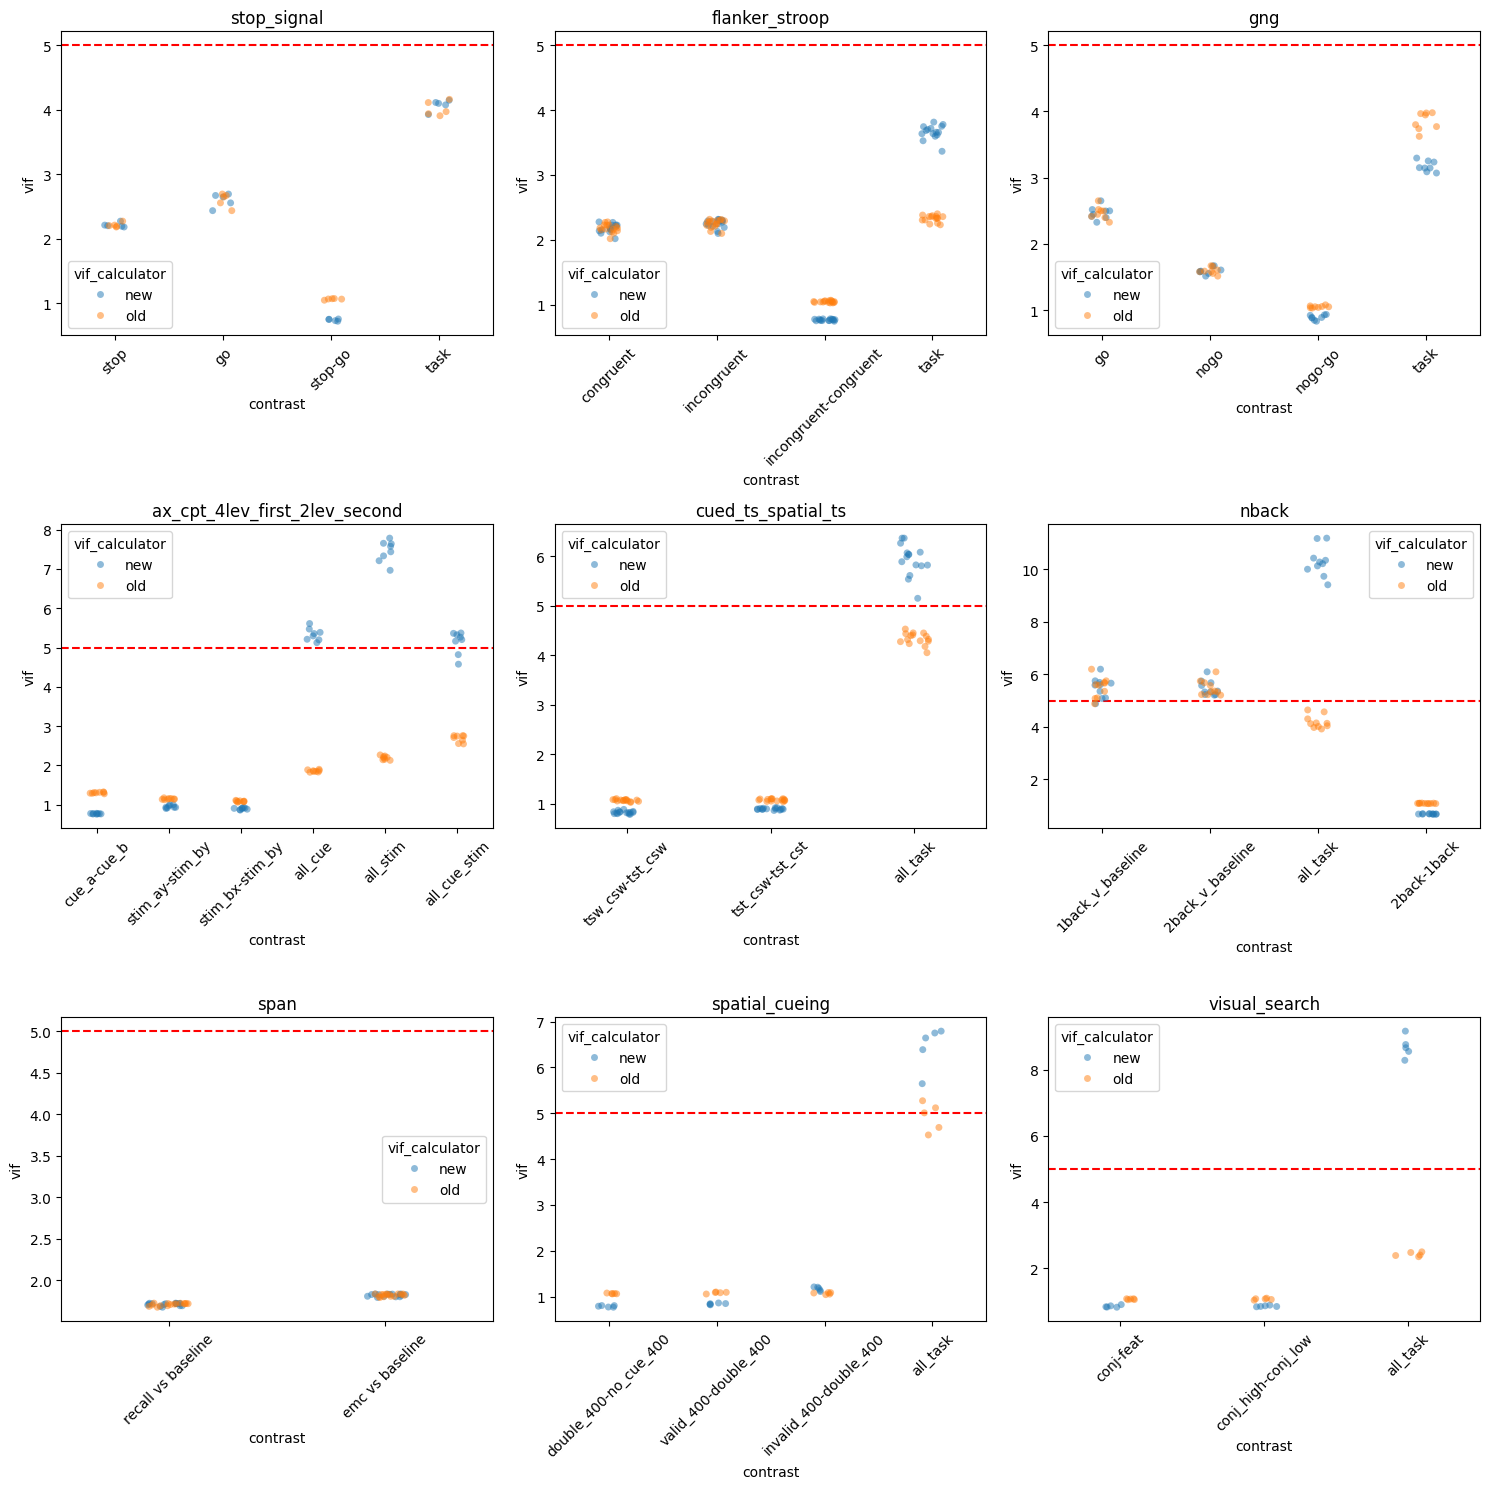

In [56]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
axs = ax.ravel()

for ind, (key, val) in enumerate(vif_out.items()):
    dat = pd.DataFrame(val)
    dat_long = pd.melt(dat, var_name='contrast', value_name='vif')
    dat_long['vif_calculator'] = 'new'
    dat_old = pd.DataFrame(vif_out_old[key])
    dat_long_old = pd.melt(dat_old, var_name='contrast', value_name='vif')
    dat_long_old['vif_calculator'] = 'old'
    dat_long = pd.concat([dat_long, dat_long_old])
    sns.stripplot(
        x='contrast',
        y='vif',
        hue='vif_calculator',
        data=dat_long,
        alpha=0.5,
        ax=axs[ind],
    )
    axs[ind].tick_params(axis='x', rotation=45)
    axs[ind].axhline(y=5, color='r', linestyle='--')
    axs[ind].set_title(key)
plt.tight_layout()
plt.show()

## Going back to the designs to see what the VIF distributions look like

In [8]:
outdir = (
    '/Users/jeanettemumford/Dropbox/Research/Projects/patrick/output_abs_diff_probs/'
)


def get_events_eff_data(outdir, task):
    events_all = []
    for i in range(1, 6):
        events = pd.read_pickle(f'{outdir}/{task}_events_{i}.pkl')
        events_all.extend(events)

    output_list = []

    for i in range(1, 6):
        output_list.append(pd.read_csv(f'{outdir}/{task}_output_{i}.csv'))
    output_all = pd.concat(output_list, ignore_index=True)
    output_all = output_all.loc[:, ~output_all.columns.str.contains('^Unnamed')]
    ranks = {col: np.argsort(output_all[col].to_numpy()) for col in output_all.columns}
    return events_all, output_all, ranks

In [10]:
# events_nback, output_nback, ranks_nback = get_events_eff_data(outdir, 'nback')
task = 'nback'
i = 1
events = pd.read_pickle(f'{outdir}/{task}_events_{i}.pkl')

In [11]:
len(events)

20000

In [45]:
def get_some_vifs(outdir, task, contrasts_hists, total_time):
    tr = 1.49
    events = pd.read_pickle(f'{outdir}/{task}_events_1.pkl')
    vifs = []
    contrast = []
    for event in events[:1000]:
        _, vif_loop, _ = est_eff_and_vif(
            event, tr, total_time[task], contrasts_hists[task], deriv=False
        )
        for key, val in vif_loop.items():
            vifs.append(val)
            contrast.append(key)
    dat_out = pd.DataFrame({'contrast': contrast, 'vif': vifs})
    dat_out['task'] = task
    return dat_out


In [42]:
contrasts_hists = {}

contrasts_hists['ax_cpt'] = {
    'all_cue': '.5*cue_a + .5*cue_b',
    'all_stim': '.25*stim_ax + .25*stim_ay + .25*stim_bx + .25*stim_by',
    'all_cue_stim': '1/6*cue_a +  1/6*cue_b + 1/6*stim_ax + 1/6*stim_ay + 1/6*stim_bx + 1/6*stim_by',
}

contrasts_hists['cued_ts_spatial_ts'] = {
    'all_task': '.333*tsw_csw + .333*tst_csw + .333*tst_cst',
}

contrasts_hists['nback'] = {
    'all_task': '.5*one_back + .5*two_back',
}

contrasts_hists['visual_search'] = {
    'all_task': '.25*con_high + .25*con_low + .25*feat_high + .25*feat_low',
}

In [47]:
vif_out['ax_cpt'] = vif_out['ax_cpt_4lev_first_2lev_second']
total_time['ax_cpt'] = total_time['ax_cpt_4lev_first_2lev_second']

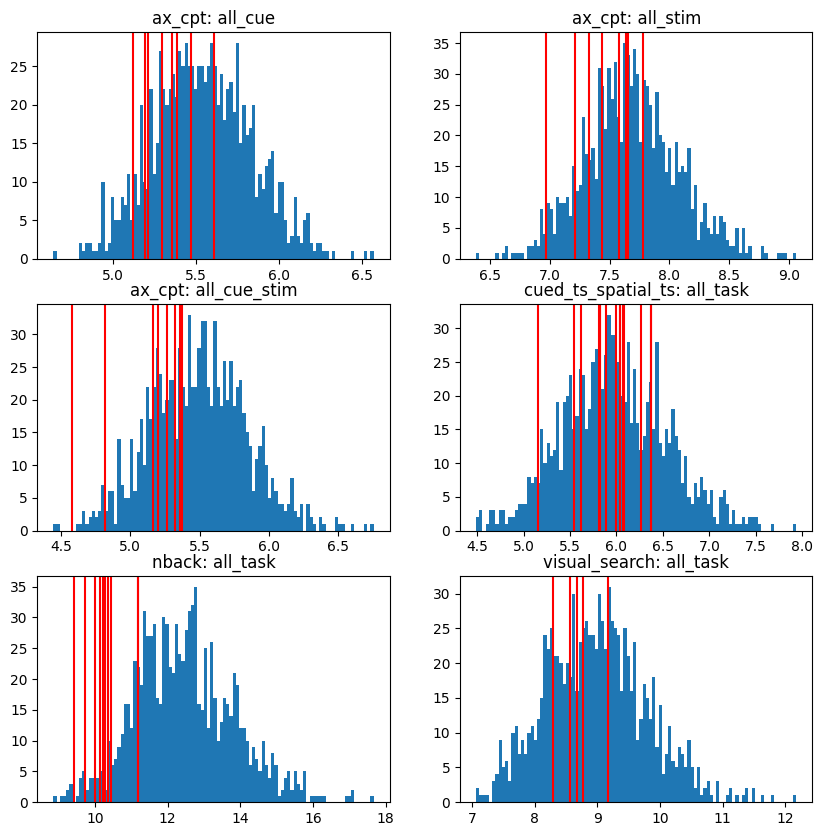

In [49]:
fig, ax = plt.subplots(3, 2, figsize=(10, 10))
axs = ax.ravel()
count = 0
for task in contrasts_hists.keys():
    dat_out = get_some_vifs(outdir, task, contrasts_hists, total_time)
    for contrast_name in dat_out['contrast'].unique():
        axs[count].hist(dat_out[dat_out['contrast'] == contrast_name]['vif'], 100)
        axs[count].set_title(f'{task}: {contrast_name}')
        for val in vif_out[task][contrast_name]:
            axs[count].axvline(val, color='r')
        count += 1
